## Using the dataset, build a model that can forecast ticket volume

In [1]:
# basic packages
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns

#data specific package
from pandas.tseries.holiday import USFederalHolidayCalendar

warnings.filterwarnings(
    action="ignore"
)

In [2]:
# importing dataset
df = pd.read_csv("Data/MR_DS.csv")

# data start and end date
start_date = '2015-11-24'
end_date = '2016-04-21'

In [3]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count
0,4/21/2016,533,984,507,239,240
1,4/20/2016,658,6035,485,225,210
2,4/19/2016,778,2450,500,196,231
3,4/18/2016,743,2502,527,192,240
4,4/17/2016,925,3080,488,217,209


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null object
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: int64(5), object(1)
memory usage: 7.1+ KB


In [5]:
# convert date to datetime object to apply transformations
df["Ticket Created Date"] = pd.to_datetime(df["Ticket Created Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Ticket Created Date                150 non-null datetime64[ns]
Total Tickets Opened               150 non-null int64
Subscription Order Count           150 non-null int64
Non Subscription Order Count       150 non-null int64
Subscription Customer Count        150 non-null int64
Non Subscription Customer Count    150 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 7.1 KB


In [6]:
# create season feature: winter, spring, summer, fall
df["Season"] = "Winter"
df["Season"][(df["Ticket Created Date"].dt.month > 2) & (df["Ticket Created Date"].dt.month <= 5)]  = "Spring"
df["Season"][(df["Ticket Created Date"].dt.month > 5) & (df["Ticket Created Date"].dt.month <= 8)]  = "Summer"
df["Season"][(df["Ticket Created Date"].dt.month > 8) & (df["Ticket Created Date"].dt.month <= 11)]  = "Fall"
df.Season.unique()

array(['Spring', 'Winter', 'Fall'], dtype=object)

In [7]:
# linear model doesn't accept categories, one hot encoding to accommodate
one_hot = pd.get_dummies(df["Season"])
df = df.drop("Season", axis=1)
df = df.join(one_hot)

In [8]:
# create holiday feature
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date)
df["Holiday"] = np.where(df["Ticket Created Date"].isin(holidays), "Holiday", "Not Holiday")
list(holidays)

[Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-01-18 00:00:00'),
 Timestamp('2016-02-15 00:00:00')]

In [9]:
one_hot = pd.get_dummies(df["Holiday"])
df = df.drop("Holiday", axis=1)
df = df.join(one_hot)

In [10]:
# check weekday vs weekend
df["Weekday"] = np.where(pd.DatetimeIndex(df["Ticket Created Date"]).weekday < 5, "Weekday", "Weekend")
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,Weekday
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,Weekday
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,Weekday
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,Weekday
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,Weekend


In [11]:
one_hot = pd.get_dummies(df["Weekday"])
df = df.drop("Weekday", axis=1)
df = df.join(one_hot)

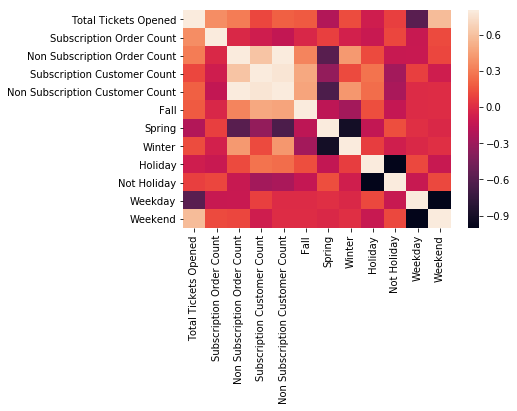

In [12]:
# check for correlation
sns.heatmap(df.corr(), vmax=0.8)

In [13]:
df.head()

,Ticket Created Date,Total Tickets Opened,Subscription Order Count,Non Subscription Order Count,Subscription Customer Count,Non Subscription Customer Count,Fall,Spring,Winter,Holiday,Not Holiday,Weekday,Weekend
0,2016-04-21,533,984,507,239,240,0,1,0,0,1,1,0
1,2016-04-20,658,6035,485,225,210,0,1,0,0,1,1,0
2,2016-04-19,778,2450,500,196,231,0,1,0,0,1,1,0
3,2016-04-18,743,2502,527,192,240,0,1,0,0,1,1,0
4,2016-04-17,925,3080,488,217,209,0,1,0,0,1,0,1


In [14]:
# original algorithm without any reduction
rgr = LinearRegression()
Y = df["Total Tickets Opened"]
X = df.iloc[:, 2:]
rgr.fit(X, Y)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nR-squared:\n', rgr.score(X, Y))


Coefficients: 
 [ 4.69198286e-02  2.85600120e-01  3.47946820e-03 -1.56994179e-01
  9.95913501e+01 -7.79436055e+01 -2.16477446e+01 -1.71464427e+01
  1.71464427e+01 -1.12980727e+02  1.12980727e+02]

Intercept: 
 551.1252942772517

R-squared:
 0.5197874818118686


## Total Tickets Opened = .05(Subscription Order Count) + 0.29(Non Subscription Order Count) - 0.35(Subscription Customer Count) - 0.16(Non Subscription Customer Count) + 99.59(Fall) - 77.94(Spring) - 21.65(Winter) - 17.15(Holiday) + 17.15(Not Holiday) - 112.98(Weekday) + 112.98(Weekend) + 551.12

In [20]:
# try to simplify equation based on correlation heatmap; keeping all seasons
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Spring", "Winter", "Holiday", "Weekday"]]
rgr.fit(X, Y)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nR-squared:\n', rgr.score(X, Y))


Coefficients: 
 [ 4.91398822e-02  3.64324091e-01  9.40159602e+01 -7.73809200e+01
 -1.66350403e+01 -4.76290749e+01 -2.32620819e+02]

Intercept: 
 709.3763537528089

R-squared:
 0.5118375075363295


## Total Tickets Opened = 0.05(Subscription Order Count) + 0.36(Non Subscription Customer Count) + 94.02(Fall) - 77.38(Spring) - 16.63(Winter) - 47.63(Holiday) - 232.62(Weekday) + 709.38

In [21]:
# further simplification, although because dataset doesn't include any "Summer", may have adverse effects with inclusion of summer data
X = df[["Subscription Order Count", "Non Subscription Customer Count", "Fall", "Winter", "Holiday", "Weekday"]]
rgr.fit(X, Y)

print('\nCoefficients: \n', rgr.coef_)
print('\nIntercept: \n', rgr.intercept_)
print('\nR-squared:\n', rgr.score(X, Y))


Coefficients: 
 [ 4.91398822e-02  3.64324091e-01  1.71396880e+02  6.07458797e+01
 -4.76290749e+01 -2.32620819e+02]

Intercept: 
 631.9954337972763

R-squared:
 0.5118375075363295


## Total Tickets Opened = 0.05(Subscription Order Count) + 0.36(Non Subscription Customer Count) + 171.40(Fall) + 60.75(Winter) - 47.63(Holiday) - 232.62(Weekday) + 631.99